In [1]:
import pandas as pd
import numpy as np
import patsy
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df_all = pd.read_csv('movie_details.csv')

In [3]:
movie_df=df_all

In [4]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8319 entries, 0 to 8318
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movie          8319 non-null   object
 1   Title          8319 non-null   object
 2   Distributor    8033 non-null   object
 3   Release        8319 non-null   object
 4   MPAA           4285 non-null   object
 5   time           8278 non-null   object
 6   Genres         8293 non-null   object
 7   Domestic       8319 non-null   object
 8   International  8319 non-null   object
 9   Worldwide      8319 non-null   object
 10  Opening        7397 non-null   object
 11  Budget         1702 non-null   object
 12  Actor_1        8083 non-null   object
 13  Actor_2        7960 non-null   object
 14  Actor_3        7858 non-null   object
 15  Actor_4        7753 non-null   object
dtypes: object(16)
memory usage: 1.0+ MB


# Data Cleaning

In [5]:
# Get rid of the rest of rows with nulls
movie_df = movie_df[pd.notnull(movie_df['Distributor'])]
movie_df = movie_df[pd.notnull(movie_df['time'])]
movie_df = movie_df[pd.notnull(movie_df['Genres'])]
movie_df = movie_df[pd.notnull(movie_df['Opening'])]
movie_df = movie_df[pd.notnull(movie_df['Budget'])]
movie_df = movie_df[pd.notnull(movie_df['MPAA'])]

In [6]:
# converting Object dtypes to float 
movie_df['Domestic']= movie_df['Domestic'].str.replace('$', '').str.replace(',', '').astype(float)
movie_df['International']= movie_df['International'].str.replace('–', '0').str.replace('$', '').str.replace(',', '').astype(float)
movie_df['Worldwide']= movie_df['Worldwide'].str.replace('$', '').str.replace(',', '').astype(float)
movie_df['Opening']= movie_df['Opening'].str.replace('$', '').str.replace(',', '').astype(float)
movie_df['Budget']= movie_df['Budget'].str.replace('$', '').str.replace(',', '').astype(float)


In [7]:
movie_df['Release']= movie_df['Release'].str.replace('Feb 29 2013', 'Feb 28 2013')
movie_df['Release'] = pd.to_datetime(movie_df['Release'])
movie_df['Distributor']= movie_df['Distributor'].str.replace('See full company information', '')

In [8]:
# Drop duplicates movies
movie_df.drop_duplicates(subset=['Title', 'Domestic'], inplace=True)

In [9]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 8213
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   movie          1293 non-null   object        
 1   Title          1293 non-null   object        
 2   Distributor    1293 non-null   object        
 3   Release        1293 non-null   datetime64[ns]
 4   MPAA           1293 non-null   object        
 5   time           1293 non-null   object        
 6   Genres         1293 non-null   object        
 7   Domestic       1293 non-null   float64       
 8   International  1293 non-null   float64       
 9   Worldwide      1293 non-null   float64       
 10  Opening        1293 non-null   float64       
 11  Budget         1293 non-null   float64       
 12  Actor_1        1293 non-null   object        
 13  Actor_2        1293 non-null   object        
 14  Actor_3        1293 non-null   object        
 15  Actor_4        1291 n

# Exploratory Data Analysis (EDA)

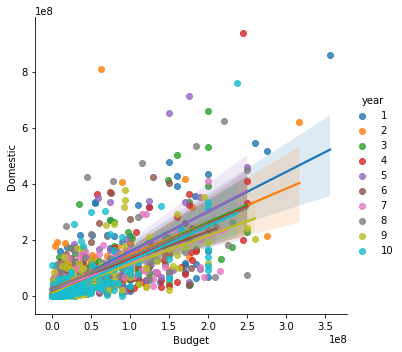

In [28]:
sns_lmplot = sns.lmplot(x="Budget", y="Domestic", hue="year", data=movie_df)
sns_lmplot.savefig("lmplot.png")

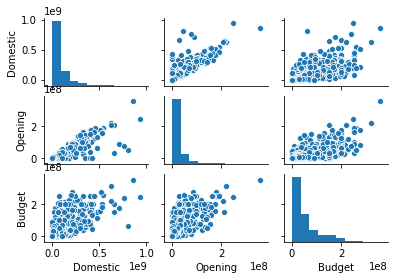

In [10]:
sns_plot = sns.pairplot(movie_df.loc[:,['Domestic','Opening', 'Budget']], height=1.2, aspect=1.5);
sns_plot.savefig("pairplot.png")

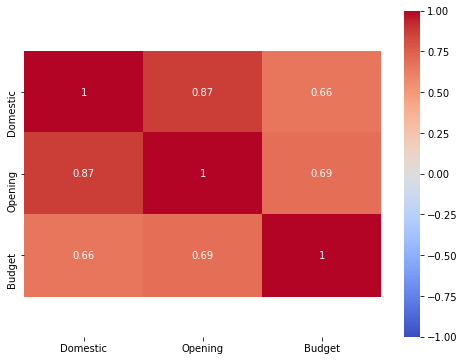

In [11]:
# fix the first and the last row cut in half of the heatmap plot
plt.figure(figsize=(8,6))
ax = sns.heatmap(movie_df.loc[:,['Domestic','Opening', 'Budget']].corr(), annot=True, vmin=-1, vmax=1,  cmap="coolwarm")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.get_figure().savefig("heatmap.png")

In [12]:
movie_df.loc[:,['Domestic','Opening', 'Budget']].describe().T

,count,mean,std,min,25%,50%,75%,max
Domestic,1293.0,7.938375e+07,1.032326e+08,8708.0,20218921.0,45216793.0,100206256.0,936662225.0
Opening,1293.0,2.321633e+07,3.161201e+07,1316.0,5853061.0,13535374.0,28525613.0,357115007.0
Budget,1293.0,5.472550e+07,5.593338e+07,15000.0,15000000.0,35000000.0,75000000.0,356000000.0


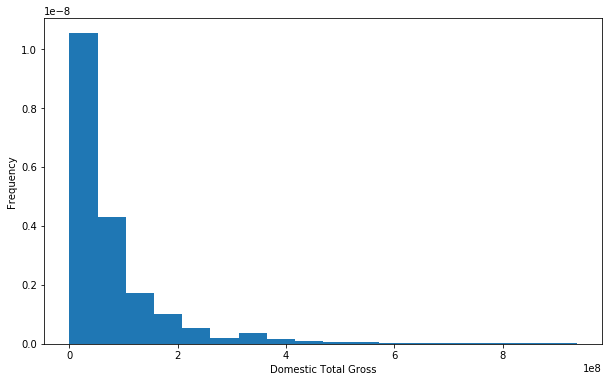

In [13]:
# create histogram for Domestic Gross Total
plt.figure(figsize=[10,6])
movie_df["Domestic"].plot.hist(density=True, bins = 18)
plt.xlabel("Domestic Total Gross")
plt.savefig("dist.png")
plt.show()

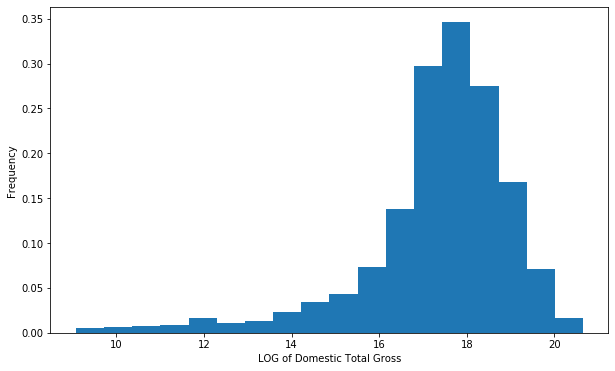

In [14]:
# create histogram for Log of Domestic Gross Total
plt.figure(figsize=[10,6])
np.log(movie_df["Domestic"]).plot.hist(density=True, bins = 18)
plt.xlabel("LOG of Domestic Total Gross")
plt.savefig("dist_log.png")
plt.show()

In [15]:
# Log target variable
movie_df['log_dtg'] = np.log(movie_df.Domestic)

In [16]:
# Create your feature matrix (X) and target vector (y)
X = movie_df.loc[:,['Opening', 'Budget']]
y = movie_df.loc[:,'log_dtg']

model = sm.OLS(y, X, data=movie_df)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                log_dtg   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              766.8
Date:                Sat, 08 Aug 2020   Prob (F-statistic):                   3.25e-220
Time:                        17:50:53   Log-Likelihood:                         -5024.2
No. Observations:                1293   AIC:                                  1.005e+04
Df Residuals:                    1291   BIC:                                  1.006e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
def run_models(X,y,kf):
       
    #Split data into train, test and validation (%60 - %20 - %20)
    X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 42)

    #LinearReg
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred_lm = lm.predict(X_test)
    print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
    print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
    print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')
    print(f'Linear Regression CV train : {cross_val_score(lm, X_train, y_train, cv=kf).mean():.3f}')
    print(f'Linear Regression MAE : {mean_absolute_error(y_test, y_pred_lm):.3f}')
    
    #Poly
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    y_pred = lm_poly.predict(X_test_poly)
    print(f'Degree 2 Polynomial Regression train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
    print(f'Degree 2 Polynomial Regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
    print(f'Degree 2 Polynomial Regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')
    print(f'Degree 2 Polynomial CV train : {cross_val_score(lm_poly, X_train_poly, y_train, cv=kf).mean():.3f}')
    print(f'Degree 2 Polynomial Regression MAE : {mean_absolute_error(y_test, y_pred):.3f}')
    
    #PolyRidge
    alpha_poly_ri = 10**np.linspace(-2,2,200)
    lm_poly_ri = RidgeCV(alphas=alpha_poly_ri, cv=kf)
    lm_poly_ri.fit(X_train_poly, y_train)
    lm_poly_ri_mdl = Ridge(alpha = lm_poly_ri.alpha_) 
    lm_poly_ri_mdl.fit(X_train_poly, y_train)
    y_pred_polyrid = lm_poly_ri_mdl.predict(X_test_poly)
    
    print(f'Ridge Polynomial Regression train R^2: {lm_poly_ri_mdl.score(X_train_poly, y_train):.3f}')
    print(f'Ridge Polynomial Regression val R^2: {lm_poly_ri_mdl.score(X_val_poly, y_val):.3f}')
    print(f'Ridge Polynomial Regression test R^2: {lm_poly_ri_mdl.score(X_test_poly, y_test):.3f}')
    print(f'Ridge Polynomial CV train : {cross_val_score(lm_poly_ri_mdl, X_train_poly, y_train, cv=kf).mean():.3f}')
    print(f'Ridge Polynomial alpha : {lm_poly_ri.alpha_:.3f}')
    print(f'Ridge Polynomial Regression MAE : {mean_absolute_error(y_test, y_pred_polyrid):.3f}')
    
    #Ridge
    alpha_ri = 10**np.linspace(-2,2,200)
    lm_ri = RidgeCV(alphas=alpha_ri, cv=kf)
    lm_ri.fit(X_train, y_train)
    lm_ri_mdl = Ridge(alpha = lm_ri.alpha_) 
    lm_ri_mdl.fit(X_train, y_train)
    y_pred_ri = lm_ri_mdl.predict(X_test)
    
    print(f'Ridge Regression train R^2: {lm_ri_mdl.score(X_train, y_train):.3f}')
    print(f'Ridge Regression val R^2: {lm_ri_mdl.score(X_val, y_val):.3f}')
    print(f'Ridge Regression test R^2: {lm_ri_mdl.score(X_test, y_test):.3f}')
    print(f'Ridge Regression CV train : {cross_val_score(lm_ri_mdl, X_train, y_train, cv=kf).mean():.3f}')
    print(f'Ridge Regression alpha : {lm_ri.alpha_:.3f}')
    print(f'Ridge Regression MAE : {mean_absolute_error(y_test, y_pred_ri):.3f}')
    
    #Lasso
    alpha_las = 10**np.linspace(-2,2,200)
    lm_las = LassoCV(alphas=alpha_las, cv=kf)
    lm_las.fit(X_train, y_train)
    lm_las_mdl = Lasso(alpha = lm_las.alpha_) 
    lm_las_mdl.fit(X_train, y_train)
    y_pred_la = lm_las_mdl.predict(X_test)

    print(f'Lasso Regression train R^2: {lm_las_mdl.score(X_train, y_train):.3f}')
    print(f'Lasso Regression val R^2: {lm_las_mdl.score(X_val, y_val):.3f}')
    print(f'Lasso Regression test R^2: {lm_las_mdl.score(X_test, y_test):.3f}')
    print(f'Lasso Regression CV train : {cross_val_score(lm_las_mdl, X_train, y_train, cv=kf).mean():.3f}')
    print(f'Lasso Regression alpha : {lm_las.alpha_:.3f}')
    print(f'Lasso Regression MAE : {mean_absolute_error(y_test, y_pred_la):.3f}')    
       

In [18]:
run_models(X,y,10)

Linear Regression train R^2: 0.361
Linear Regression val R^2: 0.382
Linear Regression test R^2: 0.392
Linear Regression CV train : 0.350
Linear Regression MAE : 0.848
Degree 2 Polynomial Regression train R^2: 0.499
Degree 2 Polynomial Regression val R^2: 0.510
Degree 2 Polynomial Regression test R^2: 0.483
Degree 2 Polynomial CV train : 0.432
Degree 2 Polynomial Regression MAE : 0.780
Ridge Polynomial Regression train R^2: 0.499
Ridge Polynomial Regression val R^2: 0.510
Ridge Polynomial Regression test R^2: 0.483
Ridge Polynomial CV train : 0.432
Ridge Polynomial alpha : 65.932
Ridge Polynomial Regression MAE : 0.780
Ridge Regression train R^2: 0.361
Ridge Regression val R^2: 0.382
Ridge Regression test R^2: 0.392
Ridge Regression CV train : 0.350
Ridge Regression alpha : 0.010
Ridge Regression MAE : 0.848
Lasso Regression train R^2: 0.361
Lasso Regression val R^2: 0.382
Lasso Regression test R^2: 0.392
Lasso Regression CV train : 0.350
Lasso Regression alpha : 87.036
Lasso Regression

# Feature Engineering

In [19]:
movie_df['year'] = 2020 - movie_df.Release.dt.year

In [20]:
# Add rating dummy variables to df
movie_df = pd.concat([movie_df.drop('MPAA', axis=1), pd.get_dummies(movie_df['MPAA'])], axis=1)

# Rename 'PG-13' MPAA column
movie_df = movie_df.rename(columns = {'PG-13':'PG_13'}) 

In [21]:
# Write function to create 'season' feature based on 'month'
def which_season(row):
    winter = [12, 1, 2]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    if row['month'] in winter:
        return('winter')
    if row['month'] in spring:
        return('spring')
    if row['month'] in summer:
        return('summer')
    if row['month'] in fall:
        return('fall')

# Create new column of 'month' based on Release
movie_df['month'] = movie_df.Release.dt.month

# Create 'season' column
movie_df['season'] = movie_df.apply(lambda row: which_season(row), axis=1)

# Convert categorical feature 'season' to dummy variables and add dummy variables to df
movie_df = pd.concat([movie_df.drop('season', axis=1), pd.get_dummies(movie_df['season'])], axis=1)

# Delete 'month' column --> don't need it anymore
del movie_df['month']

In [22]:
# Create new columns of running_time in minute based on time
movie_df['hour'] = (movie_df['time'].astype(str).str[0]).astype(int)
movie_df['min'] = np.where(movie_df['time'].str.contains('min'), ((movie_df['time'].astype(str).str[5:]).str.replace('min', '')), 0).astype(int)
movie_df['running_time(min)'] = (movie_df['hour'].astype(int)*60)+movie_df['min']

# Delete 'hour' and 'min' columns --> don't need it anymore
del movie_df['hour']
del movie_df['min']

In [23]:
dist_counts = movie_df['Distributor'].value_counts()
other_dist = list(dist_counts[dist_counts <= 49].index)

movie_df['Distributor'] = movie_df['Distributor'].replace(other_dist, 'Other')

# Add Distributor dummy variables to df
movie_df = pd.concat([movie_df.drop('Distributor', axis=1), pd.get_dummies(movie_df['Distributor'])], axis=1)

# Rename Distributor releated columns
movie_df = movie_df.rename(columns = {'Paramount Pictures':'Paramount_Pictures'}) 
movie_df = movie_df.rename(columns = {'STX Entertainment':'STX_Entertainment'}) 
movie_df = movie_df.rename(columns = {'Sony Pictures Releasing':'Sony_Pictures_Releasing'}) 
movie_df = movie_df.rename(columns = {'Twentieth Century Fox':'Twentieth_Century_Fox'}) 
movie_df = movie_df.rename(columns = {'Universal Pictures':'Universal_Pictures'}) 
movie_df = movie_df.rename(columns = {'Walt Disney Studios':'Walt_Disney_Studios'}) 
movie_df = movie_df.rename(columns = {'Warner Bros.':'Warner_Bros'}) 

In [24]:
# Log target variable
movie_df['log_bdg'] = np.log(movie_df.Budget)
movie_df['log_opn'] = np.log(movie_df.Opening)

# Model Analysis 

In [25]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 0 to 8213
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   movie                    1293 non-null   object        
 1   Title                    1293 non-null   object        
 2   Release                  1293 non-null   datetime64[ns]
 3   time                     1293 non-null   object        
 4   Genres                   1293 non-null   object        
 5   Domestic                 1293 non-null   float64       
 6   International            1293 non-null   float64       
 7   Worldwide                1293 non-null   float64       
 8   Opening                  1293 non-null   float64       
 9   Budget                   1293 non-null   float64       
 10  Actor_1                  1293 non-null   object        
 11  Actor_2                  1293 non-null   object        
 12  Actor_3                  1293 non-

In [26]:
X = movie_df.loc[:,['log_opn', 'log_bdg', 
                    'year',
                    'G', 'PG', 'PG_13', 'R',
                    'fall', 'spring', 'summer', 'winter',
                    'Lionsgate', 'Other', 'Paramount_Pictures', 'Sony_Pictures_Releasing', 'Twentieth_Century_Fox', 
                    'Universal_Pictures', 'Walt_Disney_Studios', 'Warner_Bros'
                    ]]
y = movie_df.loc[:,'log_dtg']

model = sm.OLS(y, X, data=movie_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                log_dtg   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     251.8
Date:                Sat, 08 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:51:46   Log-Likelihood:                -1614.7
No. Observations:                1293   AIC:                             3263.
Df Residuals:                    1276   BIC:                             3351.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
log_opn                   

In [27]:
run_models(X,y,10)

Linear Regression train R^2: 0.759
Linear Regression val R^2: 0.799
Linear Regression test R^2: 0.692
Linear Regression CV train : 0.738
Linear Regression MAE : 0.583
Degree 2 Polynomial Regression train R^2: 0.810
Degree 2 Polynomial Regression val R^2: 0.793
Degree 2 Polynomial Regression test R^2: 0.662
Degree 2 Polynomial CV train : 0.734
Degree 2 Polynomial Regression MAE : 0.601
Ridge Polynomial Regression train R^2: 0.797
Ridge Polynomial Regression val R^2: 0.804
Ridge Polynomial Regression test R^2: 0.733
Ridge Polynomial CV train : 0.756
Ridge Polynomial alpha : 100.000
Ridge Polynomial Regression MAE : 0.536
Ridge Regression train R^2: 0.758
Ridge Regression val R^2: 0.801
Ridge Regression test R^2: 0.696
Ridge Regression CV train : 0.740
Ridge Regression alpha : 79.341
Ridge Regression MAE : 0.581
Lasso Regression train R^2: 0.758
Lasso Regression val R^2: 0.803
Lasso Regression test R^2: 0.691
Lasso Regression CV train : 0.740
Lasso Regression alpha : 0.010
Lasso Regressio

Ridge Polynominal Regression is best model for our dataset

# Assumption 1: Regression is linear in parameters and correctly specified

In [47]:
def final_polyri(X,y,kf):
    #Split data into train, validation and  test (%60 - %20 - %20)
    X, X_test, y, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .25, random_state = 42)

    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    #PolyRidge
    alpha_poly_ri = 10**np.linspace(-2,2,200)
    lm_poly_ri = RidgeCV(alphas=alpha_poly_ri, cv=kf)
    lm_poly_ri.fit(X_train_poly, y_train)
    lm_poly_ri_mdl = Ridge(alpha = lm_poly_ri.alpha_) 
    lm_poly_ri_mdl.fit(X_train_poly, y_train)
    y_pred = lm_poly_ri_mdl.predict(X_test_poly)
 
    fig = plt.figure(figsize=(20,5))

    #reg fit plot
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=.7)
    plt.plot(np.linspace(10,20,10), np.linspace(10,20,10))
    plt.title("Regression Fit")
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    
    #residual plot
    plt.subplot(1, 3, 2)
    res = y_test - y_pred
    plt.scatter(y_pred, res, alpha=.7)
    plt.title("Residual plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    #Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    fig.savefig("subplot.png")

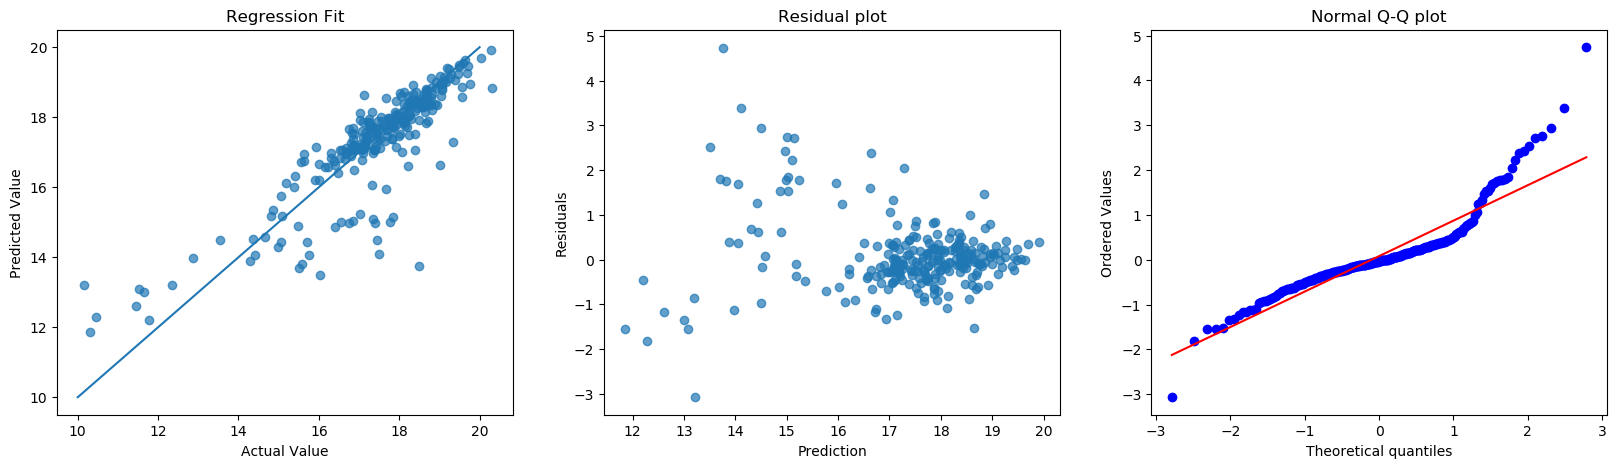

In [54]:
final_polyri(X,y,10)

# Assumption 2: Residuals should be normally distributed with zero mean¶

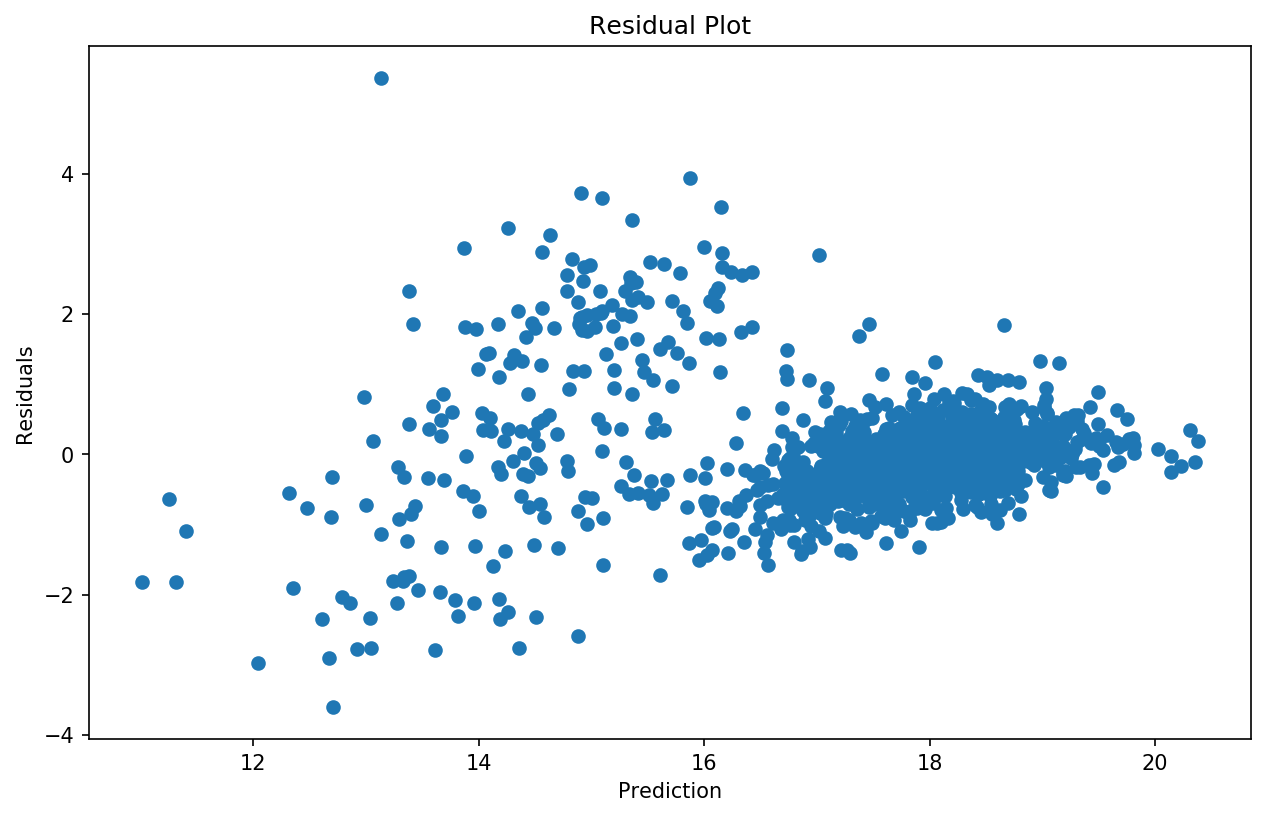

In [55]:
movie_model = sm.OLS(y, X, data=movie_df)

resultsl = movie_model.fit()

plt.figure(figsize=(10,6),dpi=150),
plt.style.use('default')
plt.scatter(resultsl.predict(), resultsl.resid);
plt.title("Residual Plot")
plt.ylabel("Residuals")
plt.xlabel("Prediction")
plt.savefig("Resid.png")
plt.show()


# Assumption 3: Homoscedasticity test for residuals

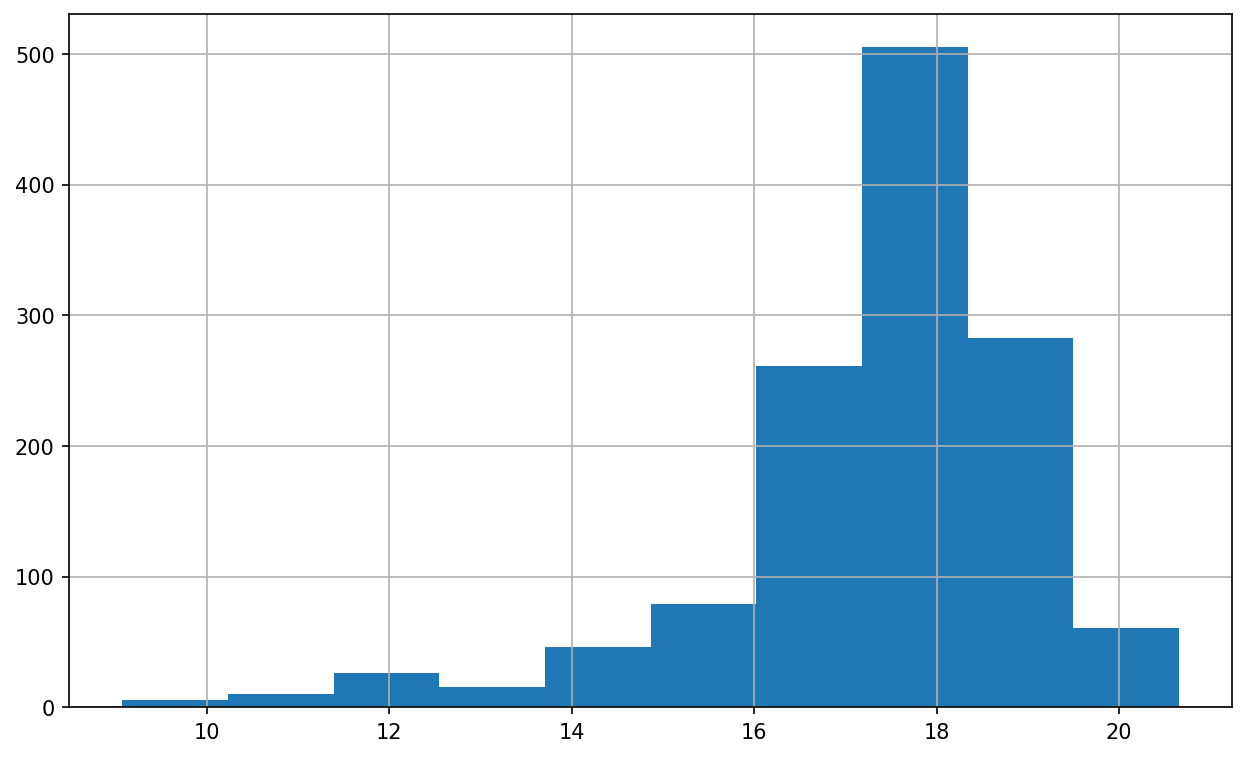

In [56]:
# create histogram
plt.figure(figsize=(10,6),dpi=150),

y.hist();

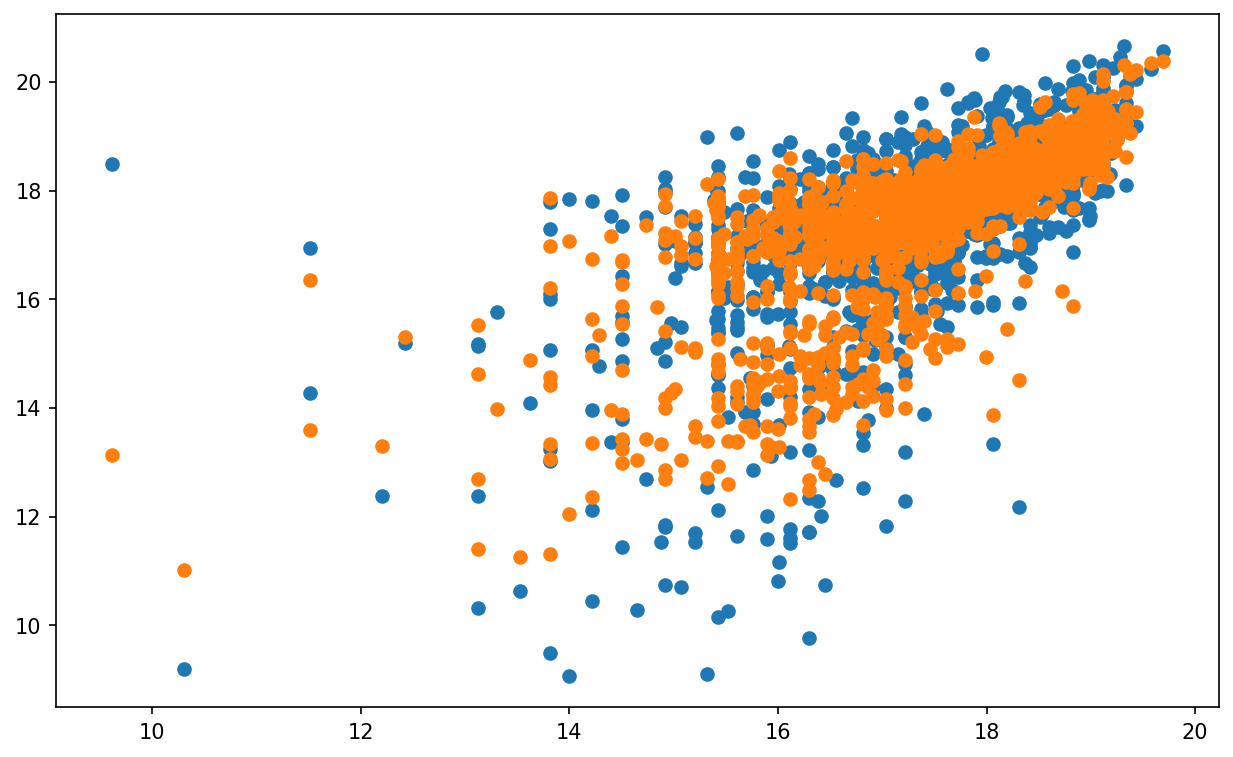

In [57]:
# quick reg plot
plt.figure(figsize=(10,6),dpi=150),


plt.scatter(X.log_bdg,y)
plt.scatter(X.log_bdg,movie_df.predict);

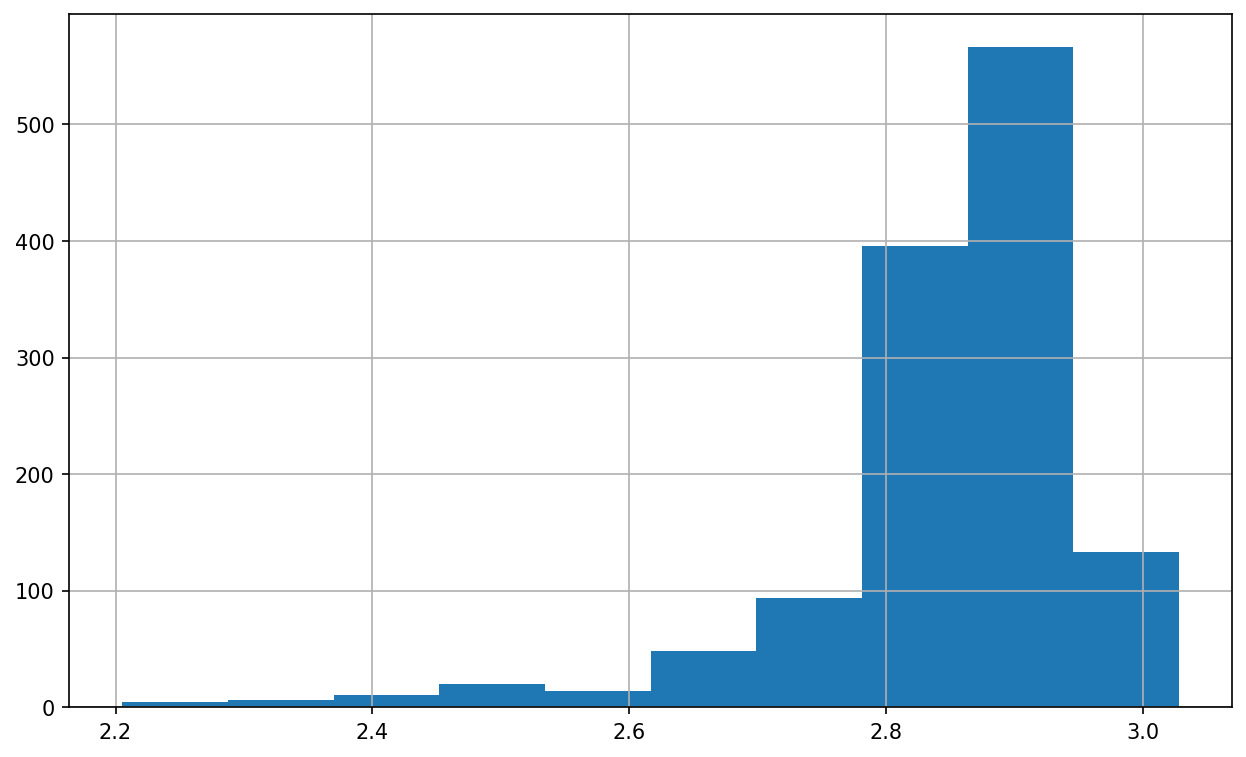

In [58]:
plt.figure(figsize=(10,6),dpi=150),

np.log(y).hist();

Lambda: 0.2625115435018778


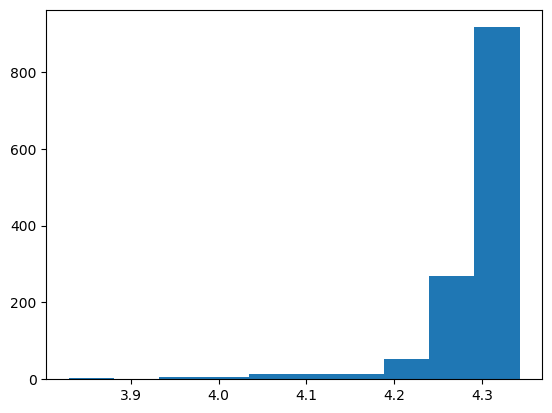

In [59]:
lamb=stats.boxcox_normmax(movie_df.Domestic, brack=(-1.9, 1.9)) 
print("Lambda:", lamb)
y_t=(np.power(movie_df.Domestic,-0.2282)-1)/-0.2282

plt.hist(y_t);

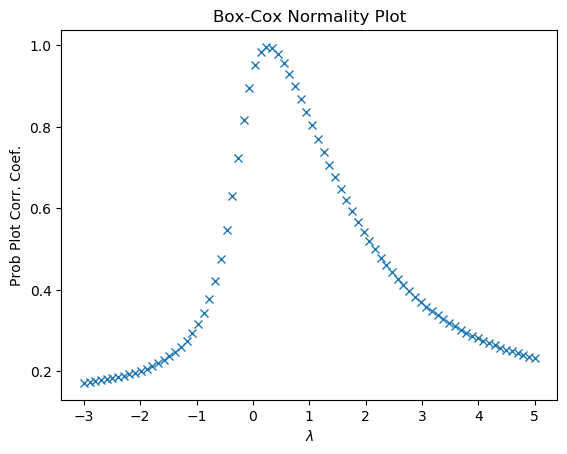

In [60]:
# plot to show optimal lambda values
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(movie_df.Domestic, -3, 5, plot=ax)

# Assumption 4: Detecting correlation between residuals and observations

In [61]:
# combine date and time into a single datetime column
movie_df["DATE_TIME"] = pd.to_datetime(movie_df.Release , format="%Y-%m-%d")
movie_df.head(3)

,movie,Title,Release,time,Genres,Domestic,International,Worldwide,Opening,Budget,...,Sony_Pictures_Releasing,Twentieth_Century_Fox,Universal_Pictures,Walt_Disney_Studios,Warner_Bros,log_bdg,log_opn,predict,resid,DATE_TIME
0,https://www.boxofficemojo.com/title/tt4154796/...,Avengers: Endgame,2019-04-26,3 hr 1 min,Action\n \n Adventure\n \n ...,858373000.0,1.939428e+09,2.797801e+09,357115007.0,356000000.0,...,0,0,0,1,0,19.690441,19.693568,20.379913,0.190636,2019-04-26
1,https://www.boxofficemojo.com/title/tt6105098/...,The Lion King,2019-07-19,1 hr 58 min,Adventure\n \n Animation\n \n ...,543638043.0,1.113305e+09,1.656943e+09,191770759.0,260000000.0,...,0,0,0,1,0,19.376192,19.071811,20.141899,-0.028105,2019-07-19
2,https://www.boxofficemojo.com/title/tt1979376/...,Toy Story 4,2019-06-21,1 hr 40 min,Adventure\n \n Animation\n \n ...,434038008.0,6.393566e+08,1.073395e+09,120908065.0,200000000.0,...,0,0,0,1,0,19.113828,18.610541,20.139150,-0.250508,2019-06-21


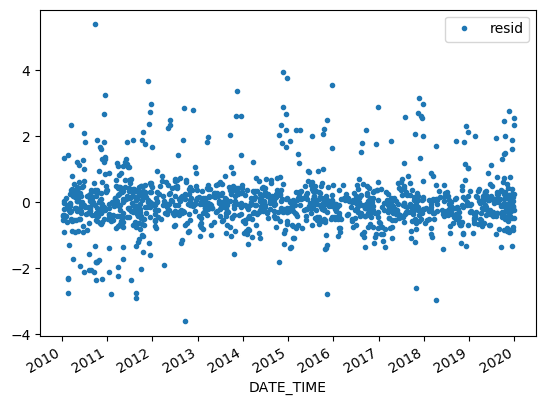

In [62]:
ts = movie_df[['DATE_TIME','resid']].set_index('DATE_TIME')
ts.plot(style=".");

# there seems to be no pattern, so we're good!

# Assumption 5: multicollinearity test according to Condition Number

In [63]:
movie_model5 = sm.OLS(y, X, data=movie_df)

results5 = movie_model5.fit()

results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     251.8
Date:                Sat, 08 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:13:50   Log-Likelihood:                -1614.7
No. Observations:                1293   AIC:                             3263.
Df Residuals:                    1276   BIC:                             3351.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
log_opn                     0.5963      0.015     38.646      0.000       0.566       0.627
log_bdg                     0.1969      0.026      7.574      0.000       0.146       0.248
year                       -0.0304      0.008     -3.732      0.000      -0.046      -0.014
G                           2.2073      0.297      7.431      0.000       1.625       2.790
PG                          1.8833      0.179     10.524      0.000       1.532       2.234
PG_13                       1.8183      0.177     10.259      0.000       1.471       2.166
R                           1.7920      0.165     10.845      0.000       1.468       2.116
fall                        1.8878      0.169     11.158      0.000       1.556       2.220
spring                      1.7902      0.174     10.263      0.000       1.448       2.132
summer                      1.9198      0.174     11.032      0.000       1.578       2.261
winter                      2.1031      0.173     12.134      0.000       1.763       2.443
Lionsgate                   0.8506      0.116      7.362      0.000       0.624       1.077
Other                       0.8160      0.076     10.751      0.000       0.667       0.965
Paramount_Pictures          1.1448      0.115      9.972      0.000       0.920       1.370
Sony_Pictures_Releasing     0.9436      0.118      7.979      0.000       0.712       1.176
Twentieth_Century_Fox       0.9032      0.112      8.039      0.000       0.683       1.124
Universal_Pictures          0.9439      0.105      8.973      0.000       0.738       1.150
Walt_Disney_Studios         1.1798      0.133      8.860      0.000       0.919       1.441
Warner_Bros                 0.9191      0.109      8.456      0.000       0.706       1.132
==============================================================================
Omnibus:                      295.581   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1399.200
Skew:                           0.991   Prob(JB):                    1.47e-304
Kurtosis:                       7.695   Cond. No.                     1.15e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.71e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""